# Comparing neural networks

In this module, we show how we can compare different models.

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import QuantLib as ql
import time

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from IPython import display

import HestonUtils
from HestonNN import Net

%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU


## Checking learning curves

Here we show how to check the learning curves of a model.

Note that Run 133 is our final narrow model $\mathcal{NN}_{narrow}$ and Run 134 is our final wide model $\mathcal{NN}_{wide}$. However, the bulk of our training for $\mathcal{NN}_{narrow}$ was actually done in Run 59 (10000 epochs), and in Run 133 a single epoch of training was performed in order to center the errors. Similarly Run 60 carries the bulk of the training for $\mathcal{NN}_{wide}$ (10000 epochs), and in one additional epoch Run 134 centers the errors.

As a result, the complete losses can be formed by appending the separate losses of the two runs, which we perform below:

In [21]:
narrow_train = np.hstack((np.load('train_losses/run_59.npy'),np.load('train_losses/run_133.npy')))
narrow_loss  = np.hstack((np.load('losses/run_59.npy'), np.load('losses/run_133.npy')))

wide_train = np.hstack((np.load('train_losses/run_60.npy'), np.load('train_losses/run_134.npy')))
wide_loss  = np.hstack((np.load('losses/run_60.npy'), np.load('losses/run_134.npy')))

Now we plot the learning curve for $\mathcal{NN}_{narrow}$:

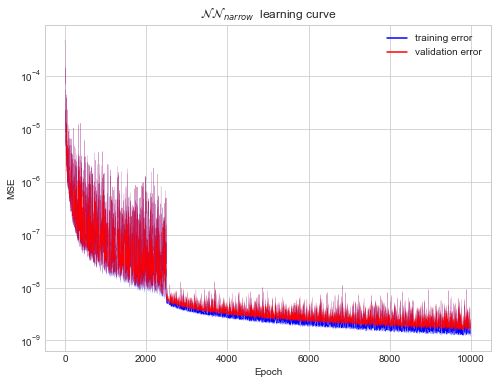

In [22]:
plt.semilogy(narrow_train, lw=0.1, c='b', label='training loss')
plt.semilogy(narrow_loss, lw=0.1, c='r', label='testing loss')
custom_lines = [Line2D([0],[0],c='b'),
                Line2D([0],[0],c='r')]
plt.title('$\mathcal{NN}_{narrow}$  learning curve')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(custom_lines, ['training error','validation error'])
plt.show()

Now we plot the learning curve for $\mathcal{NN}_{wide}$:

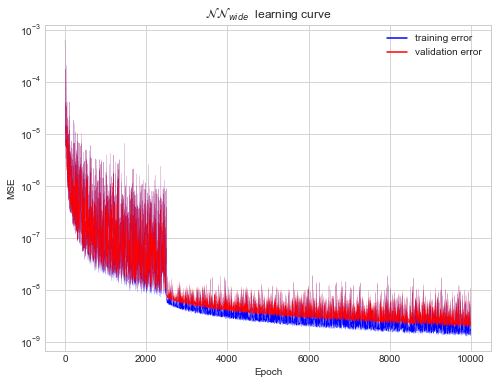

In [24]:
plt.semilogy(wide_train, lw=0.1, c='b', label='training loss')
plt.semilogy(wide_loss, lw=0.1, c='r', label='testing loss')
custom_lines = [Line2D([0],[0],c='b'),
                Line2D([0],[0],c='r')]
plt.title('$\mathcal{NN}_{wide}$  learning curve')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(custom_lines, ['training error','validation error'])
plt.show()

Now we print the final losses of our models:

In [25]:
print('final losses of trained narrow model: ', narrow_train[-1], narrow_loss[-1])
print('final losses of trained wide model: ', wide_train[-1], wide_loss[-1])

final losses of trained narrow model:  1.1911581e-09 1.5370025e-09
final losses of trained wide model:  1.2844458e-09 1.9213997e-09


## Supplementary testing
We now compare a few activation functions via 5-fold cross validation. That is, we split the training data into five "blocks", and then use four blocks as the training data and validate using the fifth. Each block will be validated on once, so we will have 5 trials for each activation function. We load our validation losses from each of the trials:

In [26]:
losses_Softplus = np.array([np.load(f'losses/run_{100+i}.npy') for i in range(1,6)])
losses_ReLU     = np.array([np.load(f'losses/run_{105+i}.npy') for i in range(1,6)])
losses_PReLU    = np.array([np.load(f'losses/run_{110+i}.npy') for i in range(1,6)])
losses_ELU      = np.array([np.load(f'losses/run_{115+i}.npy') for i in range(1,6)])

We plot the validation losses against each other:

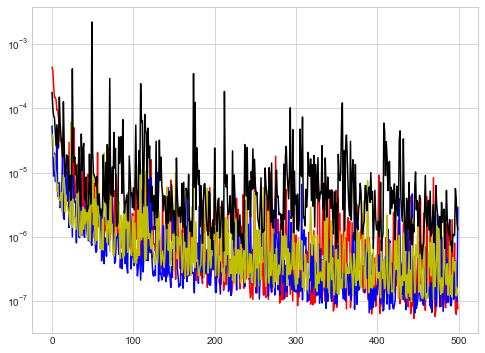

In [27]:
plt.semilogy(losses_Softplus[0],c='r')
plt.semilogy(losses_PReLU[0],c='b')
plt.semilogy(losses_ReLU[0],c='y')
plt.semilogy(losses_ELU[0],c='k')

By the nature of stochastic gradient descent, the above losses are rather noisy and we can't immediately discern which activation function is best in this preliminary testing. We might first consider: rather than plotting the loss after each epoch, why don't we plot the cumulative minimum loss after each epoch? This can be thought of as evaluating the *potential* of a given model, since we are training over a relatively short number of epochs (500), and we saw from above that the losses themselves are rather noisy. We do so below:

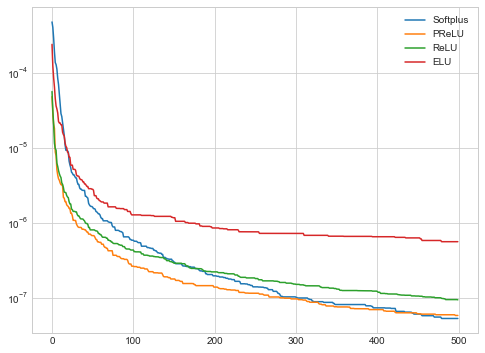

In [30]:
test1 = np.mean(np.minimum.accumulate(losses_Softplus,axis=1),axis=0)
test2 = np.mean(np.minimum.accumulate(losses_PReLU,axis=1),axis=0)
test3 = np.mean(np.minimum.accumulate(losses_ReLU,axis=1),axis=0)
test4 = np.mean(np.minimum.accumulate(losses_ELU,axis=1),axis=0)
plt.semilogy(test1, label='Softplus')
plt.semilogy(test2, label='PReLU')
plt.semilogy(test3, label='ReLU')
plt.semilogy(test4, label='ELU')
plt.legend()
plt.show()

We can immediately see how the Softplus function and PReLU function have the best preliminary performance. In particular the Softplus function's "potential" seems to be the best because its slope is steeper.

We now plot the cumulative minimum loss for each of the 5 folds:

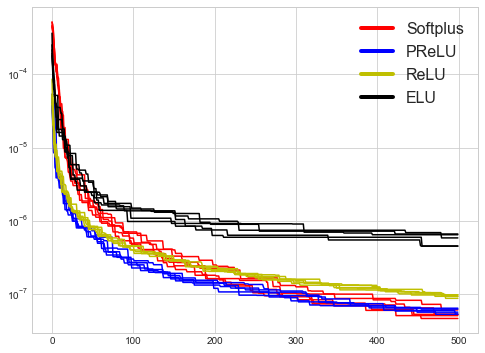

In [31]:
for i in range(5):
    plt.semilogy(np.minimum.accumulate(losses_Softplus[i]),c='r')
for i in range(5):
    plt.semilogy(np.minimum.accumulate(losses_PReLU[i]),c='b')
for i in range(5):
    plt.semilogy(np.minimum.accumulate(losses_ReLU[i]),c='y')
for i in range(5):
    plt.semilogy(np.minimum.accumulate(losses_ELU[i]),c='k')
colors = ['r','b','y','k']
lines = [Line2D([0],[0], color=c, lw=4) for c in colors]
labels = ['Softplus', 'PReLU', 'ReLU', 'ELU']
plt.legend(lines, labels, fontsize=16)
plt.show()

Once again, we see that PReLU and Softplus perform the best. We can check the final values:

In [33]:
print(np.min(losses_Softplus,axis=1))
print(np.min(losses_PReLU,axis=1))
print(np.min(losses_ReLU,axis=1))
print(np.min(losses_ELU,axis=1))

[5.2996086e-08 6.0904270e-08 4.6542961e-08 5.0918040e-08 5.3016691e-08]
[6.4240098e-08 5.6751116e-08 5.3077823e-08 6.2465148e-08 5.3555777e-08]
[9.7307606e-08 8.7654485e-08 9.7717894e-08 9.2654588e-08 9.3413924e-08]
[4.5399122e-07 4.5143491e-07 5.8492861e-07 6.6131344e-07 6.4611686e-07]


We can see that Softplus has the lowest final minimum value for 4 of the folds, and PReLU has the lowest final minimum value for 1 fold.

In the end, we select the Softplus function because from this preliminary testing it has the best performance, and also because it's useful to note that PReLU has another batch of learnable parameters that must be learned, and therefore training takes longer for it.